<a href="https://colab.research.google.com/github/tmarmedaziz/CARLA-APIs-for-autonomous-driving/blob/master/New_yolov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/dhia.txt', 'r') as f:
  l = f.read().splitlines()
print(len(l))

9131


In [ ]:
!apt update
#!apt upgrade -y
!uname -m && cat /etc/*release
!gcc --version
!uname -r

In [ ]:
!nvidia-smi

Thu Apr 28 13:21:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%cd  /content/drive/MyDrive/P2M/yolov4

/content/drive/.shortcut-targets-by-id/13mP3_FixtQ271WEfzgR1NaR1-hUsJVqo/yolov4


In [ ]:
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
%cd darknet

/content/drive/.shortcut-targets-by-id/13mP3_FixtQ271WEfzgR1NaR1-hUsJVqo/yolov4/darknet


In [ ]:
!ls -l

In [ ]:
!apt install libopencv-dev python-opencv ffmpeg

In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile

%pycat Makefile

In [ ]:
!make

In [ ]:
!unzip /content/drive/MyDrive/P2M/Data/archive.zip -d /content/

In [ ]:
!mv /content/bdd100k/bdd100k/images/100k/train/testB/* /content/bdd100k/bdd100k/images/100k/train/
!find /content/bdd100k/bdd100k/images/100k/train/trainB -name '*.*' | xargs mv --target-directory=/content/bdd100k/bdd100k/images/100k/train

In [ ]:
import glob
labels_files_name = glob.glob("/content/bdd100k_labels_release/bdd100k/labels/*.json")
images_files_name = glob.glob("/content/bdd100k/bdd100k/images/100k/train/*.jpg") 

In [ ]:
import json
def search_in_json_file(file_name,d={}):
  s = set()
  f = open(file_name)
  data = json.load(f)
  for img in data:
    for attribute in img.keys() :
      
      if attribute == "attributes" :
        
        for att in img[attribute].keys():
          # att == weather
          try:
            d[attribute][att][img[attribute][att]]+=1
          except:
            try:
              d[attribute][att][img[attribute][att]]=1
            except:
              try:
                d[attribute][att]={}
              except:
                d[attribute]={}
      if attribute == "labels":
        for cat in img['labels'] :
          if cat['id'] in s:
            pass
          else:
            s.add(cat['id'])
            try: 
              d[attribute][cat["category"]]+=1
            except:
              
              try:
                d[attribute][cat["category"]]=1
              except:
                d[attribute]={}
  f.close()
  return d


In [ ]:
# filename = labels_files_name[1]
d = {}
search_in_json_file("/content/drive/MyDrive/P2M/yolov4/subset.json",d)

{}

In [ ]:
%cd yolov4

/content/drive/MyDrive/P2M/yolov4


In [ ]:
del d['labels']['lane']
del d['labels']['drivable area']
del d['labels']['train']
class_name_to_id_mapping = {}
for i in range(len(list(d['labels'].keys()))):
  class_name_to_id_mapping[list(d['labels'].keys())[i]]=i
class_name_to_id_mapping

{'bike': 6,
 'bus': 4,
 'car': 2,
 'motor': 7,
 'person': 3,
 'rider': 8,
 'traffic light': 0,
 'traffic sign': 1,
 'truck': 5}

In [ ]:
def data_from_json_file(file_name):
  info_dict = {}
  f = open(file_name)
  data = json.load(f)
  for j in data:
    for i in j.keys() :
      if i == 'name':
        info_dict[j['name']] = {'bboxes':[]}
        # img = cv2.imread('/content/drive/MyDrive/P2M/Data/bdd100k/images/track/'+j['name'][:17]+'/'+j['name'])
        # info_dict[j['name']]['size'] = img.shape
      elif i == 'labels':
        for k in j[i]:
          bbox = {}
          for l in k.keys() :
            if l == 'category':
              bbox['class'] = k['category']
            elif l == 'box2d':
              bbox['box2d'] = k[l]
            elif l == 'poly2d':
              bbox['poly2d'] = k[l][0]['vertices']
          info_dict[j['name']]['bboxes'].append(bbox)
  f.close()
  return info_dict


In [ ]:
info_dict = {}
info_dict = data_from_json_file(labels_files_name[1])
len(list(info_dict.keys()))

69863

In [ ]:
# Counting number of X class
def count_boundig_box(d, class_name):
  d1 = {}
  
  for img_name in list(d.keys()):
    count = 0
    for i in d[img_name]['bboxes']:
      if i['class'] == class_name :
        count += 1
    d1[img_name] = count
  return d1

In [ ]:
# Display a dictionnary matching classes with ids
class_names = {}
for i in range(len(list(d['labels'].keys()))):
    class_names[list(d['labels'].keys())[i]]=i

In [ ]:
# Counting number of distinct classes in a dictionnary
def count_boundig_box(d):
    d1 = {}
    for img_name in list(d.keys()):
        d1[img_name] = {'traffic light': 0,'traffic sign': 0,'car': 0, 'person': 0, 'bus': 0, 'truck': 0, 'rider': 0, 'bike': 0,'motor': 0}
        for i in d[img_name]['bboxes']:
            if i['class'] in list(class_names.keys()) :
                d1[img_name][i['class']]+=1
        
    return d1

In [ ]:
count_dict = count_boundig_box(info_dict)

In [ ]:
# Apllying class filter to a dataset
# l is a list with filtred ids
l = []
for ind, k in count_dict.items():
    if (k['car'] < 5) and (k['traffic light'] < 5) and (k['traffic sign'] < 5) and (k['person'] < 5):
        l.append(ind)
len(l)

7599

In [ ]:
with open(labels_files_name[1]) as fp:
    data = json.load(fp)

In [ ]:
# creating same dataset json format to be input of my functions
jf = [k for k in data if k['name'] in l]
# Saving this subdataset to a json file
with open('subset.json', 'w') as fp:
    json.dump(jf, fp)

In [ ]:
len(jf)

7986

In [ ]:
l[50][0]

'012979cd-e13274a9.jpg'

In [ ]:
# search the new dataset labels
filtered_dict = {}
search_in_json_file('subset.json', filtered_dict)
# del filtered_dict['labels']['lane']
# del filtered_dict['labels']['drivable area']
del filtered_dict['labels']['train']

In [ ]:
filtered_dict

{'attributes': {'scene': {'city street': 6711,
   'gas stations': 1,
   'highway': 580,
   'parking lot': 9,
   'residential': 674,
   'tunnel': 4,
   'undefined': 6},
  'timeofday': {'dawn/dusk': 595,
   'daytime': 5063,
   'night': 2324,
   'undefined': 3},
  'weather': {'clear': 3618,
   'foggy': 15,
   'overcast': 1154,
   'partly cloudy': 538,
   'rainy': 525,
   'snowy': 593,
   'undefined': 1541}},
 'labels': {'bike': 7210,
  'bus': 1853,
  'car': 78978,
  'motor': 3002,
  'person': 27530,
  'rider': 4326,
  'traffic light': 34555,
  'traffic sign': 33850,
  'truck': 3801}}

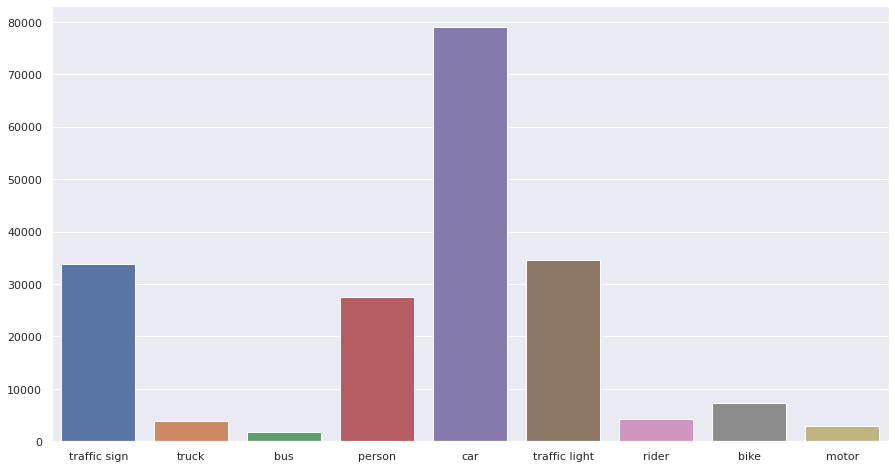

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
s1 = sns.barplot(x = list(filtered_dict['labels'].keys()), y = list(filtered_dict['labels'].values()))

In [ ]:
# Creating a new dictionnary with filtred ids
new_dict = {k:info_dict[k] for k in l}

In [ ]:
import seaborn as sns

In [ ]:
# Saving the filtred dictionnary to json file
# with open('data.json', 'w') as fp:
#     json.dump(dict, fp,  indent=4)

In [ ]:
import shutil
li = []
i = 1
for k in list(new_dict.keys()):
  source = '/content/bdd100k/bdd100k/images/100k/train/'+k
  destination = '/content/drive/MyDrive/P2M/yolov4/train/'+k
  try:
    shutil.copy(source, destination)
  except:
    print('error')
    li.append(k)
  i+=1

In [ ]:
images = glob.glob('/content/drive/MyDrive/P2M/yolov4/train/*.jpg')
len(images)

7599

In [ ]:
import os
import cv2
def convert_to_yolo(d):
  
  # image_w, image_h, image_c = d['size']
  i=0
  for img_name in list(d.keys()):
    print_buffer = []
    img_path = '/content/drive/MyDrive/P2M/yolov4/train/'+img_name
    img = cv2.imread(img_path)
    image_h, image_w, _ = img.shape
    for labels in d[img_name]['bboxes']:
      try:
        class_id = class_name_to_id_mapping[labels["class"]]
        b_center_x = (labels['box2d']["x1"] + labels['box2d']["x2"]) / 2 
        b_center_y = (labels['box2d']["y1"] + labels['box2d']["y2"]) / 2
        b_width    = (labels['box2d']["x2"] - labels['box2d']["x1"])
        b_height   = (labels['box2d']["y2"] - labels['box2d']["y1"])
        
        b_center_x = b_center_x/image_w 
        b_center_y = b_center_y/image_h 
        b_width    = b_width/image_w 
        b_height   = b_height/image_h
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

        try:
          save_file_name = '/content/drive/MyDrive/P2M/yolov4/train/'+img_name.replace("jpg", "txt")
        except:
          print('error',img_name)
      except KeyError:
          # print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        pass
    try:
      print("\n".join(print_buffer), file= open(save_file_name, 'w'))
    except:
      print("\n".join(print_buffer), file= open('/content/drive/MyDrive/P2M/yolov4/train/'+img_name.replace("jpg", "txt"), 'w'))
          



In [ ]:
convert_to_yolo(new_dict)

In [ ]:
import glob
images = glob.glob("/content/drive/MyDrive/P2M/yolov4/train/*.txt") 
len(images)

7599

In [ ]:
%cd darknet

/content/drive/MyDrive/P2M/yolov4/darknet


In [ ]:
#%cp cfg/yolov3.cfg cfg/yolo-obj.cfg
%cp cfg/yolov4-custom.cfg cfg/yolo-obj.cfg

!sed -i 's/batch=1/batch=64/g' cfg/yolo-obj.cfg
!sed -i 's/subdivisions=32/subdivisions=16/g' cfg/yolo-obj.cfg
!sed -i 's/width=608/width=416/g' cfg/yolo-obj.cfg
!sed -i 's/height=608/height=416/g' cfg/yolo-obj.cfg
!sed -i 's/max_batches = 500500/max_batches = 18000/g' cfg/yolo-obj.cfg
!sed -i 's/steps=400000,450000/steps=4800,5400/g' cfg/yolo-obj.cfg
!sed -i 's/classes=80/classes=9/g' cfg/yolo-obj.cfg
!sed -i 's/filters=255/filters=42/g' cfg/yolo-obj.cfg

In [ ]:
%pycat cfg/yolo-obj.cfg

In [ ]:
class_name_to_id_mapping

{'bike': 6,
 'bus': 4,
 'car': 2,
 'motor': 7,
 'person': 3,
 'rider': 8,
 'traffic light': 0,
 'traffic sign': 1,
 'truck': 5}

In [ ]:
all_classes = "\n".join(list(class_name_to_id_mapping.keys()))

file = """text_file = open("build/darknet/x64/data/obj.names", "w");text_file.write(all_classes);text_file.close()""" 

exec(file)
%pycat build/darknet/x64/data/obj.names

In [ ]:
import shutil
# %mkdir build/darknet/x64/data/obj
file_names = glob.glob('/content/drive/MyDrive/P2M/yolov4/train/*')
for file_path in file_names:
  try:
    shutil.move(file_path, 'build/darknet/x64/data/obj/')
  except:
    print('error')

In [ ]:
#total number of files
%ls -1 build/darknet/x64/data/obj/ | wc -l

15198


In [ ]:
obj_data = """classes= 9
train  = build/darknet/x64/data/train.txt
valid  = build/darknet/x64/data/valid.txt
names = build/darknet/x64/data/obj.names
backup = ../weights/
"""

file = """text_file = open("build/darknet/x64/data/obj.data", "w");text_file.write(obj_data);text_file.close()""" 

exec(file)
%pycat build/darknet/x64/data/obj.data

In [ ]:
##total number of .jpg & .txt files
%ls -1 build/darknet/x64/data/obj/*.jpg | wc -l
%ls -1 build/darknet/x64/data/obj/*.txt | wc -l

KeyboardInterrupt: ignored

In [ ]:
import os, fnmatch
import numpy as np

train_file = open("build/darknet/x64/data/train.txt", "w")
valid_file = open("build/darknet/x64/data/valid.txt", "w")
listOfFiles = os.listdir('build/darknet/x64/data/obj/')  
pattern = "*.jpg"  
for f_name in listOfFiles:  
  if fnmatch.fnmatch(f_name, pattern):
    if np.random.rand(1) < 0.8:
      train_file.write("build/darknet/x64/data/obj/"+f_name+"\n")
      #print ("data/obj/"+f_name)
    else:
      valid_file.write("build/darknet/x64/data/obj/"+f_name+"\n")  
      
train_file.close()
valid_file.close()

In [ ]:
#Count number of files 
!wc -l build/darknet/x64/data/train.txt
!wc -l build/darknet/x64/data/valid.txt

6052 build/darknet/x64/data/train.txt
1547 build/darknet/x64/data/valid.txt


In [ ]:
%pycat build/darknet/x64/data/train.txt

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

In [ ]:
try:
  shutil.move('/content/drive/MyDrive/P2M/yolov4/darknet/yolov4.conv.137', 'build/darknet/x64/')
except:
  print('error')

In [ ]:
%ls build/darknet/x64/

In [ ]:
!./darknet detector train build/darknet/x64/data/obj.data cfg/yolo-obj.cfg build/darknet/x64/yolov4.conv.137 -dont_show -map

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.619091), count: 25, class_loss = 4.387171, iou_loss = 8.663557, total_loss = 13.050728 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.442708), count: 7, class_loss = 0.595845, iou_loss = 0.376490, total_loss = 0.972335 
 total_bbox = 657781, rewritten_bbox = 0.764692 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.645987), count: 41, class_loss = 10.575811, iou_loss = 186.219269, total_loss = 196.795074 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.610671), count: 15, class_loss = 4.463112, iou_loss = 7.725906, total_loss = 12.189018 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.388114), count: 9, class_loss = 2.952516, iou_loss = 0.147902, total_loss = 3.100417 
 total_bbox = 65

In [ ]:
!chmod +x ./darknet

In [ ]:
!./darknet detector train build/darknet/x64/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/P2M/yolov4/weights/yolo-obj_last.weights -dont_show -map

Streaming output truncated to the last 5000 lines.
 total_bbox = 922786, rewritten_bbox = 0.762149 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.740399), count: 67, class_loss = 7.682767, iou_loss = 284.878326, total_loss = 292.561096 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.825220), count: 33, class_loss = 1.969583, iou_loss = 26.525534, total_loss = 28.495117 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.793365), count: 4, class_loss = 0.046046, iou_loss = 0.419346, total_loss = 0.465392 
 total_bbox = 922890, rewritten_bbox = 0.762063 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.677812), count: 51, class_loss = 5.839673, iou_loss = 224.386978, total_loss = 230.226654 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.867242), count: 20, class_loss = 1.157007, iou_loss = 12.448807, total_loss

In [ ]:
!./darknet detector map build/darknet/x64/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/P2M/yolov4/weights/yolo-obj_last.weights -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

In [ ]:
!./darknet detector test build/darknet/x64/data/obj.data cfg/yolo-obj.cfg /content/drive/MyDrive/P2M/yolov4/weights/yolo-obj_last.weights /content/tunisia_road.jpg -thresh 0.3

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

In [ ]:
!python darknet.py

Traceback (most recent call last):
  File "darknet.py", line 236, in <module>
    lib = CDLL(cwd + "/libdarknet.so", RTLD_GLOBAL)
  File "/usr/lib/python3.7/ctypes/__init__.py", line 364, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /libdarknet.so: cannot open shared object file: No such file or directory


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
img1 = cv2.imread('chart1.png')
img2 = cv2.imread('chart2.png')
img3 = cv2.imread('chart3.png')
img4 = cv2.imread('chart4.png')
img5 = cv2.imread('chart5.png')
img6 = cv2.imread('chart6.png')
img7 = cv2.imread('chart7.png')
img8 = cv2.imread('chart8.png')


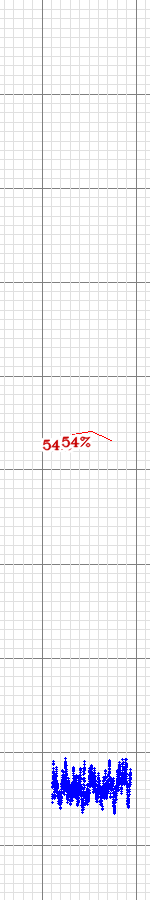

In [ ]:
cv2_imshow(img7[0:900,300:450])

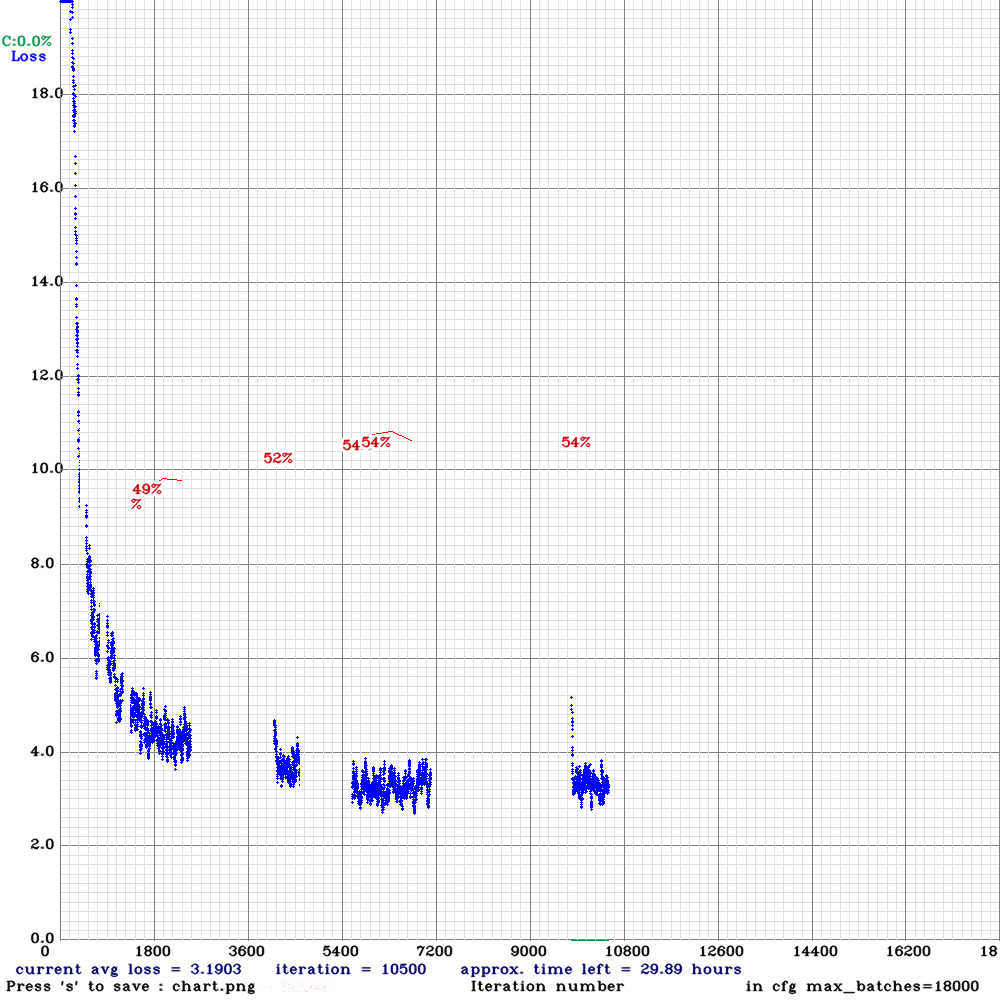

True

In [ ]:
new_img = img8.copy()
new_img[0:800,0:80] = im1[0:800,0:80]
new_img[0:800,80:120] = img2[0:800,80:120]
new_img[0:800,100:130] = img3[0:800,100:130]
new_img[0:800,130:260] = img4[0:800,130:260]
new_img[0:800,260:300] = img5[0:800,260:300]
new_img[0:900,300:450] = img7[0:900,300:450]
cv2_imshow(new_img)
cv2.imwrite('/content/final_chart.png', new_img)

In [ ]:
pwd

'/content/drive/.shortcut-targets-by-id/13mP3_FixtQ271WEfzgR1NaR1-hUsJVqo/yolov4/darknet'